# Problem Set 2021



## Author(s), contact(s), and dates:
- Author: Sophia Wilson
- Email:  ldr934@alumni.ku.dk
- Date:   3rd of January 2022

In [1]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories
import math
from uncertainties import ufloat
from scipy import stats
from scipy.stats import binom, poisson, norm           # Functions from SciPy Stats...
from importlib import reload

In [2]:
sys.path.append('../../AppStat2021/External_Functions')
import SophiasExternalFunctions as sw
from ExternalFunctions import UnbinnedLH, BinnedLH, Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

In [3]:
reload(sw); #reloading library (updating changes)

## I - Distributions and probabilities

### 1.1 Dices

**Experiment: Counting the number of 3s among 20 normal dice 1000 times**

In [4]:
N_exp = 10000
N_trials = 20

dicerolls = np.random.randint(1,7, size = (N_trials,N_exp))
N3 = np.sum(dicerolls == 3, axis = 0)  #true = 1 og false = 0

**Function parameters**

In [5]:
# Range of outcome:
xmin = -0.50001
xmax = max(N3)+0.5

# Binomial:
n = N_trials
p = 1/6 
sigma = np.sqrt(n*p*(1-p))

# Poisson:
Lambda = n * p               
#sigma = np.sqrt(n*p) 

# Gaussian:
mu = Lambda    

In [6]:
xaxis = np.linspace(xmin, xmax, N_exp)
yaxis_binom = sw.binomial_pmf(np.floor(xaxis+0.5), n, p) 
yaxis_poiss = sw.poisson_pmf(np.floor(xaxis+0.5), Lambda)     
yaxis_gauss = sw.gaussian_pdf(xaxis, n*p, np.sqrt(n*p*(1-p)))

**Plotting the distribution of N3 and the unit Poisson PDF**

[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5]


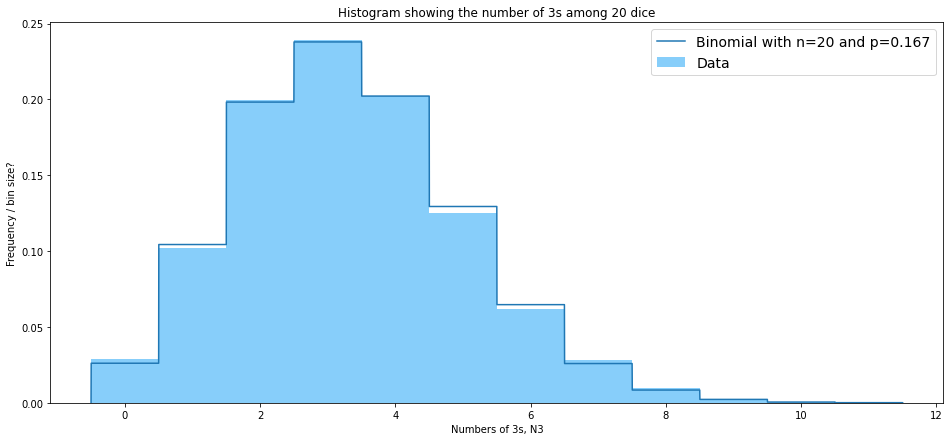

In [7]:
bins = np.linspace(-0.5,max(N3)+0.5,max(N3)+2.5)
print(bins)
#xticks = np.linspace(0,max(N3),max(N3)+2)

fig1, ax1 = plt.subplots(figsize=(16, 7)) 
hist1 = ax1.hist(N3, bins=bins, histtype='bar', color= 'lightskyblue', linewidth=2, density=True, label='Data')
ax1.set(xlabel='Numbers of 3s, N3', ylabel='Frequency / bin size?', title='Histogram showing the number of 3s among 20 dice')

ax1.plot(xaxis, yaxis_binom, '-', label=f'Binomial with n={n:2d} and p={p:.3f}')
#ax1.plot(xaxis, yaxis_poiss, '-', label=f'Poisson with lambda={Lambda:.2f}')
#ax1.plot(xaxis, yaxis_gauss, '-', label=f'Gaussian with mu={mu:.2f} and sigma={sigma:.2f}')

ax1.legend(loc='upper right', fontsize=14);
#ax1.set_xticks(xticks);

**What is the probability of getting 7 or more 3s in a roll with 20 normal dice?**

In [8]:
#From simulation (couting)
print(np.sum(N3>=7)/len(N3)*100)

4.09


In [9]:
#From simulation (integrating)
binwidth = len(bins)/(max(N3)+2)        #binwidth = 1
print(sum(hist1[0][7:]) * binwidth*100)

4.09


In [10]:
#Theoretical
sum(sw.binomial_pmf(np.arange(7,21,1),20,1/6))*100

3.7135343038672435

### 1.2 COVID19 tests,  4th of January 2021

On the 4th of January 2021, the number of Danish Covid-19 tests and positives in 24
hours were: PCR: 103261, with 2464 positives and AntiGen: 26162 with 491 positives.

**Assuming both tests are accurate (i.e. have no errors), what is the fraction of positives in
each test? And what is the probability that these fractions are statistically the same?**

In [11]:
pcr_total = 103261
ag_total = 26162
pcr_positive = 2464
ag_positive = 491

In [12]:
pcr_frac = pcr_positive/pcr_total
ag_frac = ag_positive/ag_total
pcr_sigma = np.sqrt(pcr_positive)/pcr_total
ag_sigma = np.sqrt(ag_positive)/ag_total
print('pcr fraction',pcr_frac,'+/-',pcr_sigma)
print('ag fraction',ag_frac,'+/-',ag_sigma)

dmu, dsigma, nsigma, p = sw.compare(pcr_frac, ag_frac, pcr_sigma, ag_sigma)
print(nsigma, p)

pcr fraction 0.023861864595539458 +/- 0.00048071096138874723
ag fraction 0.01876767831205565 +/- 0.0008469734655668657
5.230801869563491 1.6877632601383696e-07


**If the two tests are sampling the same population, what is the false negative rate (i.e. rate
of positive testing negative) of the AntiGen test, assuming no other test errors?**

In [13]:
print('False negative rate of the AntiGen test:',round((pcr_positive-ag_positive)*100,2),'%')

False negative rate of the AntiGen test: 197300 %


**A test has a 0.02% false positive rate and 20% false negative rate. You test 50000 persons,
finding 47 positives. What fraction of the Danish population would you estimate are infected?**

In [14]:
N_total = 50000
N_p = 47
false_p = 0.0002
false_n = 0.20

N_estimate = round(N_p + (N_total-N_p)*false_n - N_p*false_p)
print('Estimation of infected persons:', N_estimate,'persons')

Estimation of infected persons: 10038 persons


### 1.3 Voltage peaks

In [15]:
data = np.genfromtxt('data_VoltagePeaks.txt')

(1, 1000)

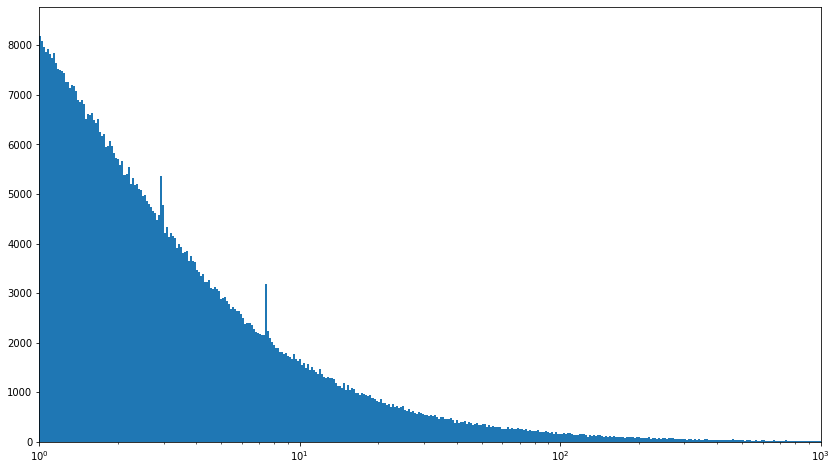

In [16]:
_, bins = np.histogram(np.log10(data + 1), bins='auto')

plt.figure(figsize=(14,8))
plt.hist(data, bins=10**bins, range=(0,1000));
plt.gca().set_xscale("log")
plt.xlim(1,1000) 

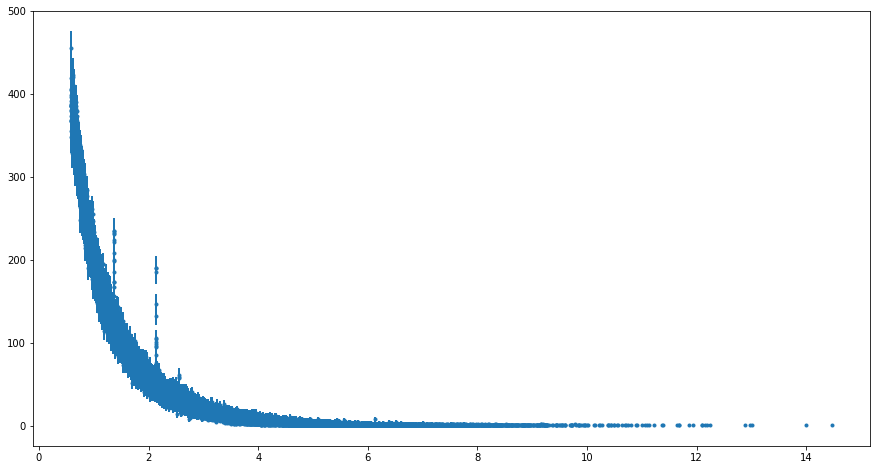

In [289]:
Nbins = 40000

fig, ax = plt.subplots(figsize=(15, 8))
counts, bin_edges = np.histogram(np.log(data+1), bins=Nbins)
#y = y[500:]
#x = 0.5*(bin_edges[1:] + bin_edges[:-1])[500:]

x = ((bin_edges[1:][counts>0] + bin_edges[:-1][counts>0])/2)[1300:]
y = counts[counts>0][1300:]

sy = np.sqrt(y) 
hist_data = ax.errorbar(x, y, sy, fmt='.', linewidth=2, label="Data")
fig;

In [290]:
reload(sw);

In [291]:
binwidth = x[1]-x[0]

In [292]:
def expfit(x,Lambda):
    return Lambda * np.exp(-x*Lambda)

def bkg(x,Nbkg,Lambda):
    return Nbkg*binwidth*expfit(x,Lambda)

def gauss_pdf(x, mu, sigma):
    return 1.0 / np.sqrt(2 * np.pi) / np.abs(sigma) * np.exp(-(x - mu)**2 / 2.0 / sigma**2)

def signal(x, Nbkg, Lambda, Nsig, mu, sigma) :
        return bkg(x,Nbkg,Lambda) + Nsig * binwidth * gauss_pdf(x, mu, sigma)

../../AppStat2021/External_Functions/SophiasExternalFunctions.py:145: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-r" (-> color='r'). The keyword argument will take precedence.
  ax.plot(x_axis, fitfunction(x_axis, *minuit_chi2.values[:]), '-r', label='Chi2 fit model result', zorder=3,color='blue')


(20482.339514750583,
 16169,
 6.906616734646497e-109,
 [1578971.9626846472,
  1.2508065781621982,
  1079.8738215493383,
  1.3739852331586964,
  0.0014009309633766503],
 [2092.6779914433664,
  0.0015025885528927008,
  40.30894425401598,
  8.948951443763872e-05,
  6.667458007690481e-05])

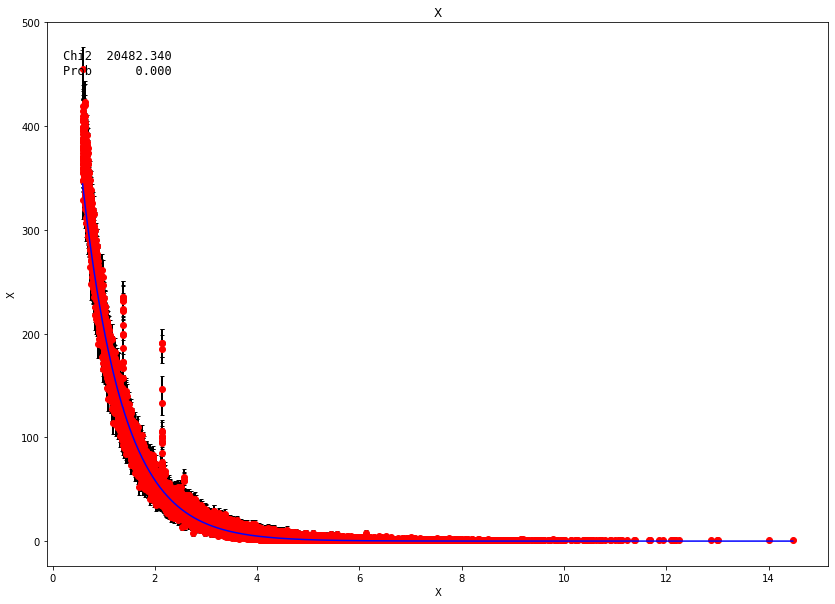

In [293]:
xaxis = np.linspace(0,14,1000)
plt.plot()
sw.chisquarefit(x, y, sy, signal, [1500000,1.2,10.652763017571429, 1.3739876963338202, 0.0015326216825511272], plot=True)

In [286]:
#sw.chisquarefit(x, y, sy, bkg, [13000,0.7], plot=True)

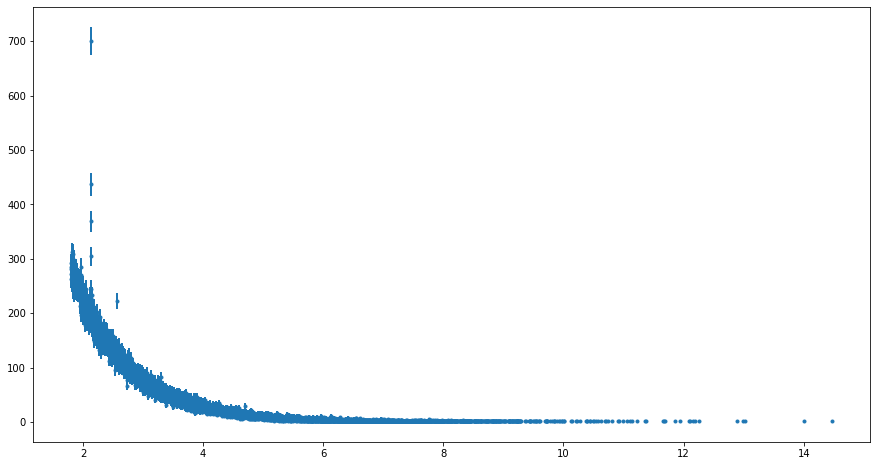

In [275]:
Nbins = 10000


fig, ax = plt.subplots(figsize=(15, 8))
y, bin_edges = np.histogram(np.log(data+1), bins=Nbins)
x = 0.5*(bin_edges[1:] + bin_edges[:-1])


x = ((bin_edges[1:][counts>0] + bin_edges[:-1][counts>0])/2)[1200:]
y = counts[counts>0][1200:]

sy = np.sqrt(y)      # This is the standard for histograms - each bin is Poisson distributed!

hist_data = ax.errorbar(x, y, sy, fmt='.', linewidth=2, label="Data")
fig;

In [129]:
len(x)

4880

In [ ]:
y = y[]
x = x[]

## II - Error propagation

### 2.1 Law of error propagation

In [23]:
'''
x1 = ufloat(1.96, 0.03)
x2 = ufloat(0.96, 0.03)

x = [x1,x2]

for i in x:
    y = 1/(1+i**2)
    z = 1/(1-i)**2
    y_ = 'y = {:.2uf}'.format(y)
    z_ = 'z = {:.2uf}'.format(z)
    print(y_,z_)
'''

"\nx1 = ufloat(1.96, 0.03)\nx2 = ufloat(0.96, 0.03)\n\nx = [x1,x2]\n\nfor i in x:\n    y = 1/(1+i**2)\n    z = 1/(1-i)**2\n    y_ = 'y = {:.2uf}'.format(y)\n    z_ = 'z = {:.2uf}'.format(z)\n    print(y_,z_)\n"

#### **Students in a statistics class have measured the gravitational acceleration g**

In [24]:
g_obs = np.array([9.54,9.36,10.02,9.87,9.98,9.86,9.86,9.81,9.79])
g_sigma = np.array([0.15,0.10,0.11,0.08,0.14,0.06,0.03,0.13,0.04])

**Assuming independent measurements, what is the best estimate of g and its uncertainty?**

In [25]:
g_mean, g_mean_sigma = sw.weightedmean(g_obs,g_sigma)
print(g_mean,g_mean_sigma)

9.824097473177613 0.01997038603519878


**What is the χ2 and its p-value? Do you find any measurements to be unlikely?**

In [26]:
reload(sw);

In [27]:
g_exp = 9.815 
sw.chisquare(g_exp, g_obs, g_sigma, 1)

(32.60304275916464, 7.260017717513591e-05)

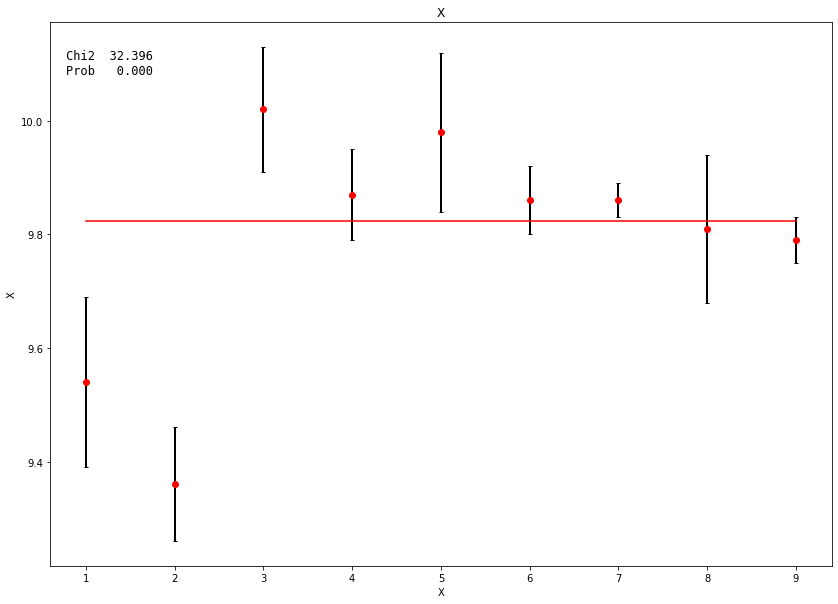

In [28]:
def confunc(x,b):
    return b*np.ones_like(x)
    
x = np.linspace(1,len(g_obs),len(g_obs))
chi2_value, Ndof_value, chi2_prob, par, par_err = sw.chisquarefit(x, g_obs, g_sigma, confunc, [9.82], plot=True)

In [29]:
print(par[0])

9.824097473178389


In [30]:
print(g_mean)

9.824097473177613


In [31]:
for i in range(len(g_obs)):
    dmu, dsigma, nsigma, p = sw.compare(g_obs[i],par[0],g_sigma[i],par_err[0])
    print(p)

0.06046089923744948
5.336385664907144e-06
0.07972422351198877
0.577733540184428
0.2702747912790999
0.5702028312531553
0.3191478428578143
0.91464239701878
0.44566117991510656


**Does your best estimate of g agree with the precision measurement 9.8158 ± 0.0001 m/s2**

In [32]:
g_precise = 9.8158
g_precise_sigma = 0.0001

In [33]:
sw.compare(g_mean, g_precise, g_mean_sigma, g_precise_sigma)

(0.008297473177613313,
 0.01997063640435283,
 0.41548366359545674,
 0.6777878718106003)

## II - Monte Carlo

### 3.1 Let u be the sum of 4 exponentially distributed numbers t, with PDF $f(t) = \frac{1}{\tau} exp(-t/\tau)$ for $t \epsilon [0, \infty[$. Let $\tau = 0.08$. 

**Generate 10000 values of u and plot these.**

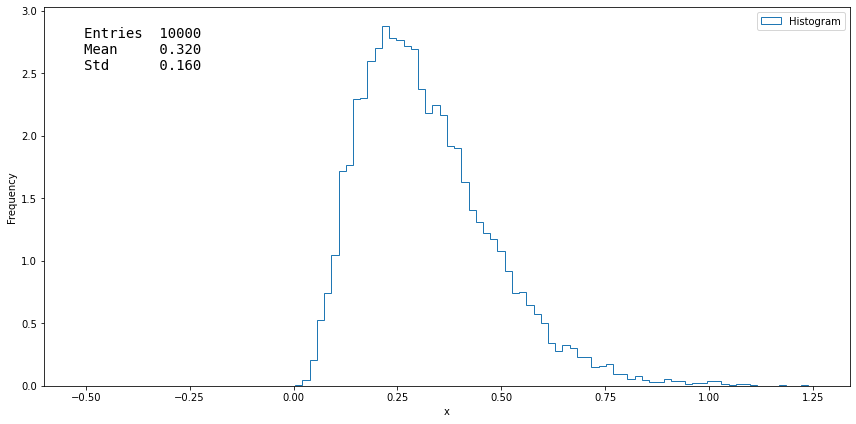

In [34]:
N_total = 10000
n = 4
tau = 0.08

t = np.random.exponential(scale=tau,size=(n,N_total))
u = np.sum(t, axis = 0)  

xmin, xmax = -0.5, max(u)
N_points = N_total
N_bins = int(np.sqrt(N_points))

sw.plot_hist(u, xmin, xmax, N_points, N_bins);

**Try to fit the distribution of u with a Gaussian and comment on the result**

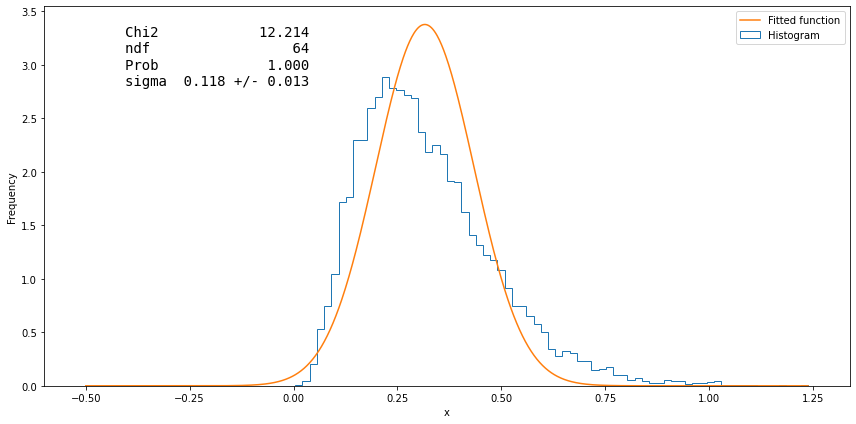

In [35]:
mu, sigma = u.mean(), u.std()
sw.chisquarefit_histogram(u, sw.gaussian_pdf, [mu, sigma], xmin, xmax, N_bins, plot=True)

**Try other functional forms to see how well you can match the distribution of u**

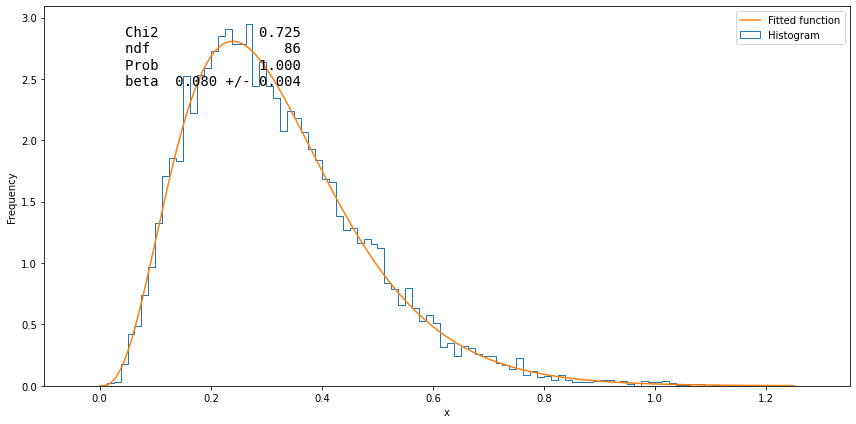

In [36]:
xmin0, xmax0 = 0, 1.25
k = 4

def erlang(x,k,beta):
    return x**(k-1)*np.exp(-x/beta)/(beta**k*math.factorial(int(k-1)))

sw.chisquarefit_histogram(u, erlang, [k, tau], xmin0, xmax0, N_bins, plot=True)

In [37]:
#fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14,10))
#sw.plot_hist(u, xmin, xmax, N_points, N_bins)

#ax[2] = sw.chisquarefit_histogram(u, erlang, [k, tau], xmin0, xmax0, N_bins, plot=True)



###  3.2 Let x follow the PDF f(x) = $C x exp(−x)$ for $x \epsilon [0, \infty[$

**Generate 1000 values of x, plot these, and determine the median of your x values**

eff = 0.1847
Chi2 value: 0.1   Ndof = 53    Prob(Chi2,Ndof) = 1.000
Fit value: a = 1.00931 +/- 0.71865
Fit value: b = 1.01810 +/- 0.34142
Fit value: d = 0.00164 +/- 0.01971


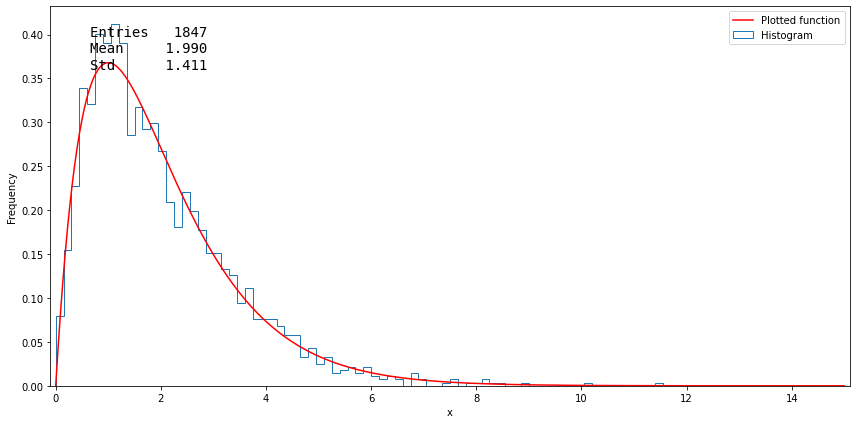

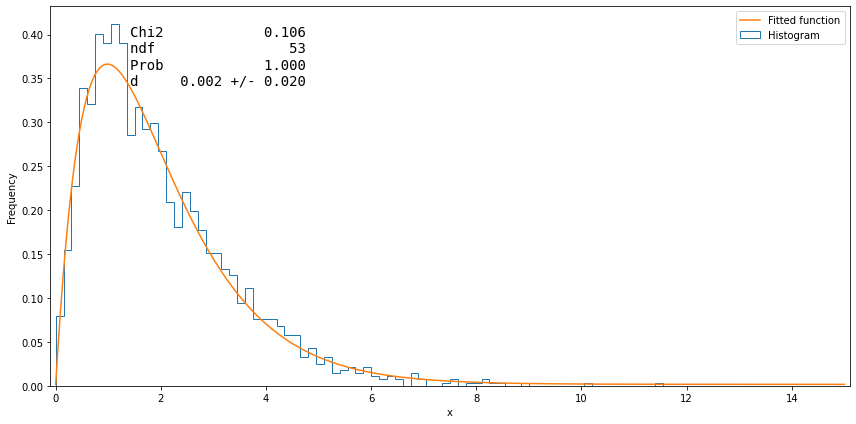

In [131]:
xmin32, xmax32 = 0, 15
c = 1

def fx_xexp(x):
    return c*x*np.exp(-x)

def fx_xexp_fit(x,a,b,d):
    return a*c*x*np.exp(-b*x)+d

x_accepted, eff = sw.acceptandreject(fx_xexp, xmin32, xmax32, N_points, N_bins)
print('eff =',eff)
sw.plot_histandfunc(x_accepted, fx_xexp, xmin32, xmax32, N_points, N_bins)
sw.chisquarefit_histogram(x_accepted, fx_xexp_fit, [1,1,0], xmin32, xmax32, N_bins, plot=True, verbose=True)

In [132]:
# Define smart function

c = 1

def fx_xexp(x):
    return c*x*np.exp(-x)

def fx_xexp_smart(x):
    return np.exp(-x/1.7)


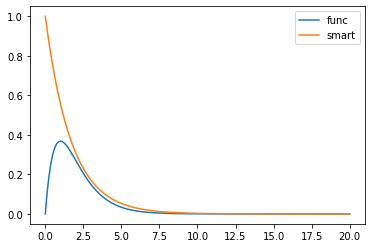

In [133]:
# Plot smart function
lam = 1/1.7

xaxis = np.linspace(0,20,1000)
y_func = fx_xexp(xaxis)
y_smartfunc = fx_xexp_smart(xaxis)
plt.plot(xaxis,y_func,label='func')
plt.plot(xaxis,y_smartfunc,label='smart')
plt.legend()

In [134]:
def smart_box(func, funcsmart, plot = False):
    x = np.linspace(0,15,1000)

    N = 100000
    N_accept = 0  
    N_reject = 0 
    x_accept = np.zeros(N)  
    
    while N_accept < N:
        r1 = np.random.random()
        x1 = -np.log(r1)*1.7
        y1 = np.random.random()*funcsmart(x1)
        if (y1 < func(x1)):        
            x_accept[N_accept] = x1
            N_accept += 1
        if (y1 > func(x1)):        
            N_reject+=1
            
    eff = N/(N+N_reject)  #N_accept = N 

    if plot == True:
        fig, ax = plt.subplots(figsize=(12, 6))
        hist_trans = ax.hist(x_accept, bins=100, histtype='step', label='Histogram', density=True)

        d = {'Entries': len(x_accept),
             'Mean': x_accept.mean(),
             'Std': x_accept.std(ddof=1),
             'Median': np.median(x_accept)
             }

        text = nice_string_output(d, extra_spacing=2, decimals=3)
        add_text_to_ax(0.05, 0.95, text, ax, fontsize=14)

        ax.legend(loc='best')
        fig.tight_layout()  
        plt.xlabel("Length [m]")
        plt.ylabel("PDF value")
        plt.show()
    
    return x_accept, eff
    

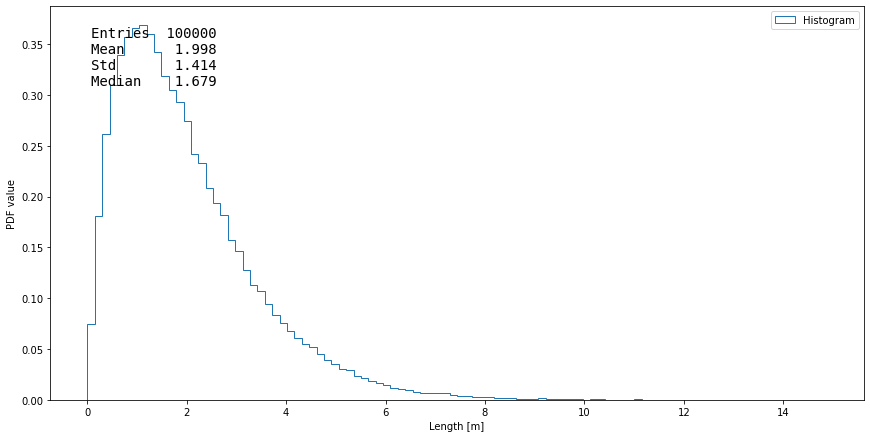

0.5891050904570866


In [135]:
x, eff = smart_box(fx_xexp, fx_xexp_smart, plot = True)
print(eff)

In [136]:
np.median(x)

1.6790309387286921

Usikkerhed på median? https://physics.stackexchange.com/questions/292871/uncertainty-propagation-upon-taking-the-median

Chi2 value: 0.0   Ndof = 83    Prob(Chi2,Ndof) = 1.000
Fit value: a = 0.99880 +/- 0.67493
Fit value: b = 1.00070 +/- 0.28036
Fit value: d = 0.00001 +/- 0.00248


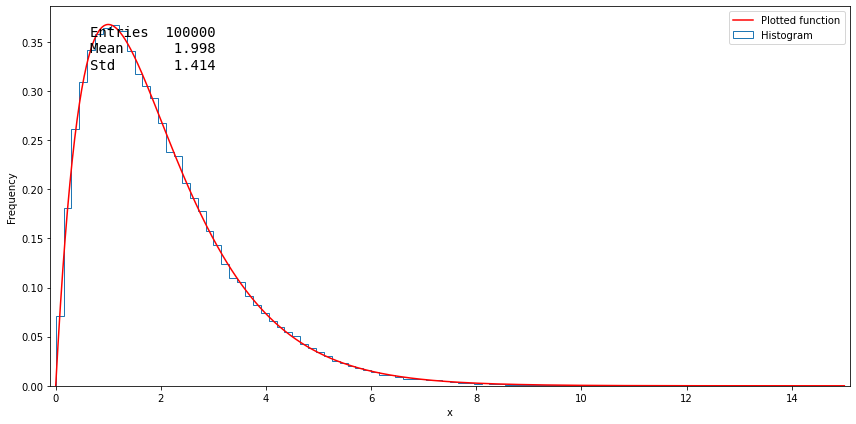

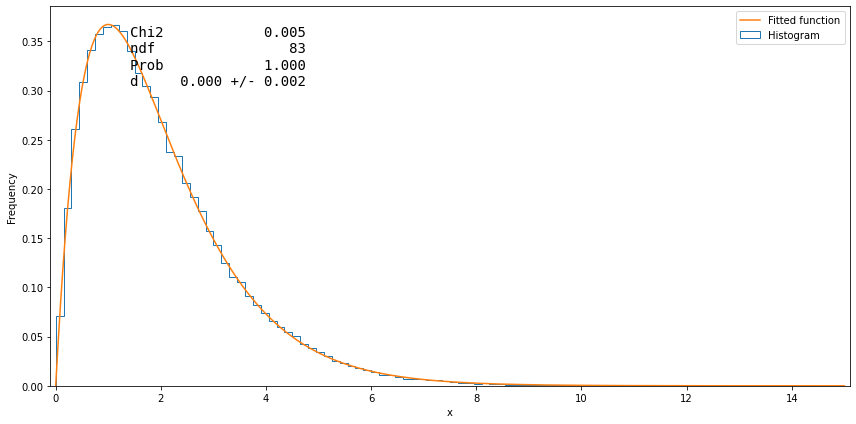

In [137]:
sw.plot_histandfunc(x, fx_xexp, xmin32, xmax32, N_points, N_bins)
sw.chisquarefit_histogram(x, fx_xexp_fit, [1,1,0], xmin32, xmax32, N_bins, plot=True, verbose=True)

# Statistical tests

###  4.1 In an observer-blinded study, 21720 persons were given two doses of the Covid-19 vaccine candidate BNT162b2 and 21728 persons two doses of placebo.

**In this study, the total number of Covid-19 cases were Nvaccine = 8 among participants
who received BNT162b2 and Nplacebo = 162 among those recieving the placebo. What is
(approximately) the probability that BNT162b2 has no effect on being infected?**

In [138]:
Nv_total = 21720
Np_total = 21728
Nv_pos = 8
Np_pos = 162

In [139]:
# Positive fraction
Nv_frac = Nv_pos/Nv_total 
Np_frac = Np_pos/Np_total

# Uncertainty on positive fraction (error propagation and Poisson uncertainty)
Nv_frac_sigma = np.sqrt(Nv_pos)/Nv_total
Np_frac_sigma = np.sqrt(Np_pos)/Np_total

# Compare numbers 
dmu, dsigma, nsigma, p = sw.compare(Nv_frac,Np_frac,Nv_frac_sigma,Np_frac_sigma)

print(nsigma, p)

11.810830083019624 3.431565443890656e-32


**Based on the total number of Covid-19 cases above, calculate a 68% confidence interval of
the BNT162b2 vaccine efficacy, $\epsilon$ = (Nplacebo − Nvaccine)/Nplacebo**

In [140]:
from sympy.abc import p, v

In [141]:
v_eff = (Np_pos - Nv_pos)/Np_pos
v_eff_sigma = sw.ophob((p-v)/p,[v,p],[Nv_pos, Np_pos],[np.sqrt(Nv_pos),np.sqrt(Np_pos)])

c_int = [v_eff-v_eff_sigma,v_eff+v_eff_sigma]
print(c_int)


[0.9327319549925853, 0.9685026129086493]


**In the study, there were 10 severe Covid-19 cases, out of which 9 were in the placebo group.
With only this data, what would then be the probability that BNT162b2 had no effect?**

In [142]:
Nv_pos = 1
Np_pos = 9

# Positive fraction
Nv_frac = Nv_pos/Nv_total 
Np_frac = Np_pos/Np_total

# Uncertainty on positive fraction (error propagation and Poisson uncertainty)
Nv_frac_sigma = np.sqrt(Nv_pos)/Nv_total
Np_frac_sigma = np.sqrt(Np_pos)/Np_total

# Compare numbers 
dmu, dsigma, nsigma, p = sw.compare(Nv_frac,Np_frac,Nv_frac_sigma,Np_frac_sigma)

print(nsigma, p)

from sympy.abc import p, v
v_eff = (Np_pos - Nv_pos)/Np_pos
v_eff_sigma = sw.ophob((p-v)/p,[v,p],[Nv_pos, Np_pos],[np.sqrt(Nv_pos),np.sqrt(Np_pos)])

c_int = [v_eff-v_eff_sigma,v_eff+v_eff_sigma]
print(c_int)

2.5296124666472575 0.011418857127025296
[0.7717674940678377, 1.0060102837099398]


### 4.2 Deck of cards

**Drawing 4 cards with replacement, what distribution does the number of aces follow? What
is the chance of getting 3 aces or more?**

In [190]:
N_exp = 1000
N_trials = 4

drawcard = np.random.randint(2,15, size = (N_trials,N_exp))
Nace = np.sum(drawcard == 14, axis = 0)  
print(drawcard.mean())

7.90825


In [241]:
# Range of outcome:
xmin = -0.500001
xmax = max(Nace)+0.49

# Binomial:
n = N_trials
p = 1/14
sigma = np.sqrt(n*p*(1-p))

xaxis = np.linspace(xmin, xmax, N_exp)
yaxis_binom = sw.binomial_pmf(np.floor(xaxis+0.5), n, p) 

In [242]:
bins

array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5])

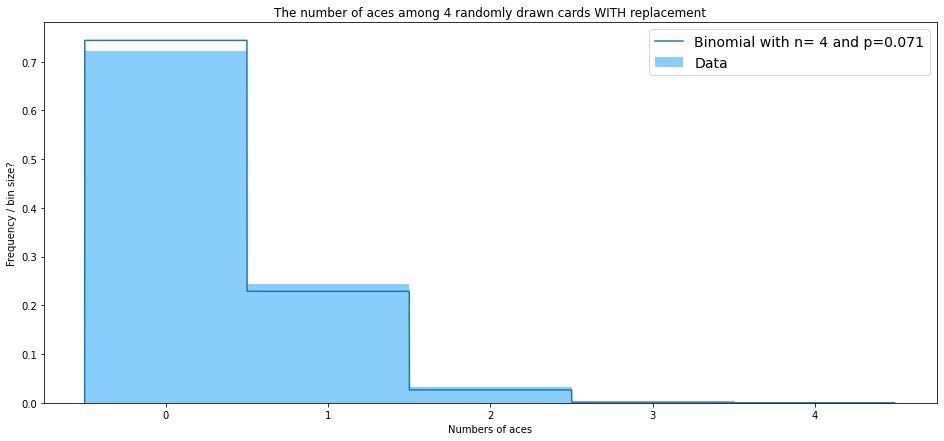

In [243]:
bins = np.linspace(-0.5,max(Nace)+0.5,max(Nace)+2.5)

fig41, ax41 = plt.subplots(figsize=(16, 7)) 
hist41 = ax41.hist(Nace, bins=bins, histtype='bar', color= 'lightskyblue', linewidth=2, density=True, label='Data')

ax41.set(xlabel='Numbers of aces', ylabel='Frequency / bin size?', title='The number of aces among 4 randomly drawn cards WITH replacement')
#ax41.hist(yaxis_binom, bins=bins,density=True)

ax41.plot(xaxis, yaxis_binom, '-', label=f'Binomial with n={n:2d} and p={p:.3f}')
#ax41.plot(xaxis, yaxis_poiss, '-', label=f'Poisson with lambda={Lambda:.2f}')
ax41.legend(loc='upper right', fontsize=14);

[7996 2004    0    0    0]


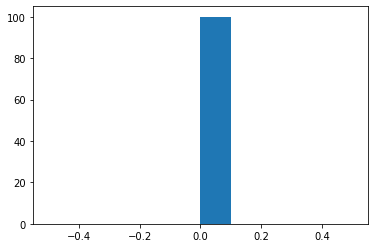

In [240]:
N_exp = 10000
xaxis = np.linspace(xmin, xmax, N_exp)

Nace_bio = sw.binomial_pmf(np.floor(xaxis+0.5), n, p) # expected 
counts_bio = np.histogram(Nace_bio,bins=bins)[0]
#plt.hist(Nace_bio,bins=bins)

#plt.hist(Nace_bio,bins=bins)

p_values = []

for i in range(100):
    drawcard = np.random.randint(2,15, size = (N_trials,N_exp))
    Nace = np.sum(drawcard == 14, axis = 0) 
    p_ks = stats.ks_2samp(Nace_bio, Nace)[1]
    p_values.append(p_ks)
    #plt.hist(Nace,bins=bins)
    
print(counts_bio)
plt.hist(p_values)
plt.show()

In [209]:
#From simulation (couting)
print(np.sum(Nace>=3)/len(Nace))

#From simulation (integrating)
binwidth = len(bins)/(max(Nace)+2)        #binwidth = 1
print(sum(hist41[0][3:]) * binwidth)

#Theoretical
print(sum(sw.binomial_pmf([3,4],4,1/14)))

0.0017
0.0015
0.0013796334860474797


**Drawing 4 cards without replacement, what is the probability of getting 3 aces or more?**

The binomial distribution is frequently used to model the number of successes in a sample of size n drawn with replacement from a population of size N. If the sampling is carried out without replacement, the draws are not independent and so the resulting distribution is a hypergeometric distribution, not a binomial one. 

In [160]:
cards = np.array(list(np.linspace(2,14,13))*4)

In [161]:
drawcard_wo = []

for _ in range(10000):
     drawcard_wo.append(np.random.choice(cards, size = (N_trials), replace = False))


drawcard_wo = np.array(drawcard_wo)
Nace_wo = np.sum(drawcard_wo == 14, axis = 1)  


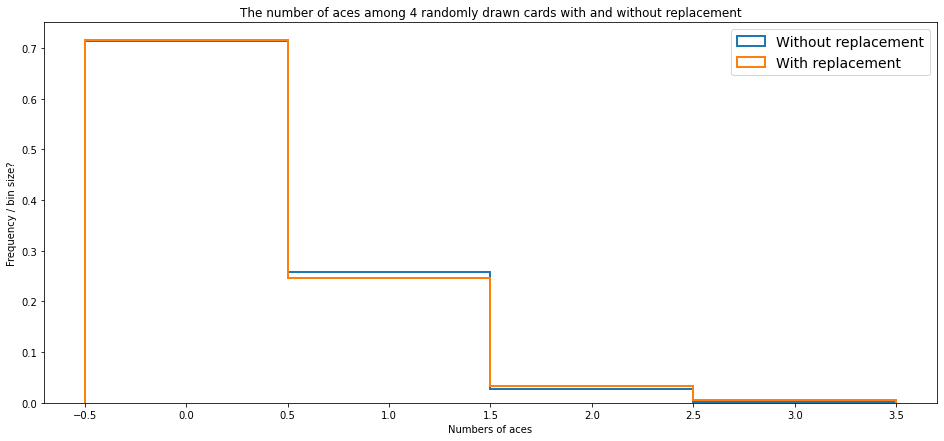

In [162]:
bins = np.linspace(-0.5,max(Nace_wo)+0.5,max(Nace_wo)+2.5)

fig1, ax1 = plt.subplots(figsize=(16, 7)) 
hist_wo = ax1.hist(Nace_wo, bins=bins, histtype='step', linewidth=2, density=True, label='Without replacement')
hist_w = ax1.hist(Nace, bins=bins, histtype='step', linewidth=2, density=True, label='With replacement')


ax1.set(xlabel='Numbers of aces', ylabel='Frequency / bin size?', title='The number of aces among 4 randomly drawn cards with and without replacement')
#ax1.plot(xaxis, yaxis_binom, '-', label=f'Binomial with n={n:2d} and p={p:.3f}')
#ax1.plot(xaxis, yaxis_poiss, '-', label=f'Poisson with lambda={Lambda:.2f}')
ax1.legend(loc='upper right', fontsize=14);

In [163]:
aces = np.array([[4/52, 3/51, 2/50, 1],
                [4/52, 3/51, 1, 2/49],
                [4/52, 1, 3/50, 2/49],
                [1, 4/51, 3/50, 2/49],
                [4/52, 3/51, 2/50, 1/49]])
  
p3aces = np.prod(aces, axis=1)
sum(p3aces)

0.0007498383968972205

**Are the cards are well shuffled? Perform at least one hypothesis test to check**

In [244]:
shuffled_cards = np.genfromtxt('data_ShuffledCards.txt', skip_header=2, usecols=(0,4,5))

In [245]:
number = shuffled_cards[:,0]
value = shuffled_cards[:,1]
suit = shuffled_cards[:,2]

Suits in the first and second half of the decks

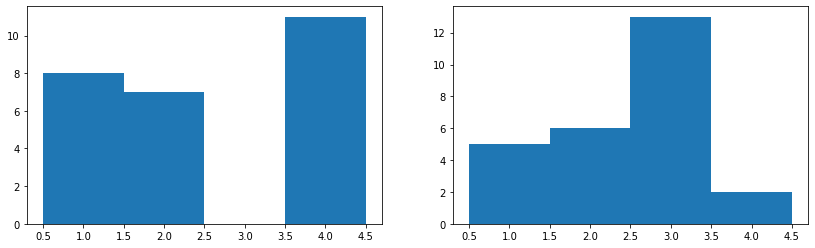

In [246]:
bins = np.linspace(0.5,4.5,5)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,4))
ax[0].hist(suit[:26], bins=bins, label = 'Suits, first half')
ax[1].hist(suit[26:], bins=bins, label = 'Suits, second half');

In [247]:
# Probability of avoiding a suit when drawing 26 cards

prod = 1

for i in range(26):
    prod *= (52.-13-i)/(52-i)

prod*4 # Multiply with four because it is subordinate which suit it is


6.551419158073676e-05

In [248]:
print(sum(value[:26] >= 11),sum(value[26:] >= 11))

7 9


Numbers of picture cards and aces in the first and second half

In [249]:
pic_first = sum(value[:26] >= 11)
pic_second = sum(value[26:] >= 11)

n_sigma = abs((pic_first - 8) / np.sqrt(52*4/14*(1-4/14))) # n = 52, p = 4/14
p = 1-stats.norm.cdf(-n_sigma,0)*2

print(n_sigma, p) #spørg jonathan om 

0.3069703067574602 0.24113402646198479


In [250]:
stats.norm.cdf(-0.3,0)*2

0.7641771556220948

Even and odd in first and second half <br>
In total there are 28 even cards and 24 uneven cards

0.5563486402641867 0.5779725419154278


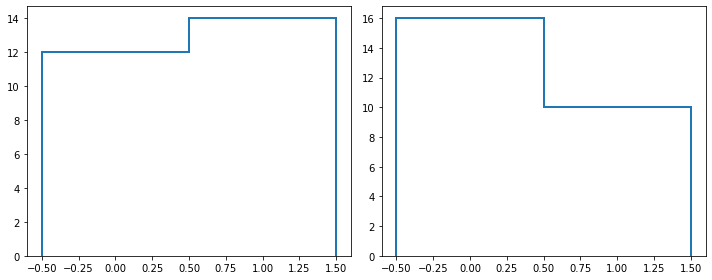

In [251]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ax = ax.flatten()

hist_oe1 = ax[0].hist(value[:26] % 2, bins=2, histtype='step', range=(-0.5, 1.5), linewidth=2)
hist_oe2 = ax[1].hist(value[26:] % 2, bins=2, histtype='step', range=(-0.5, 1.5), linewidth=2)
fig.tight_layout()

#Even cards in the first half
n_sigma = abs((hist_oe1[0][0] - 14) / np.sqrt(52*14/26*(1-14/26)))   # p = 14/26 
p = stats.norm.cdf(-n_sigma,0)*2

print(n_sigma, p) #spørg jonathan om p værdi


# Fitting Data

The cumulative solar power capacity (in MegaWatts) and price of solar power ($/W)
from 1976-2019 

**Plot the price of solar power as a function of cumulative solar power capacity**

The power law function is also plotted just to estimate good start parameters in the next task

In [252]:
solarpower = np.genfromtxt('data_SolarPower.txt', skip_header=2) #usecols=(0,4,5)
year, cumcap, price = solarpower[:,0], solarpower[:,1], solarpower[:,2]

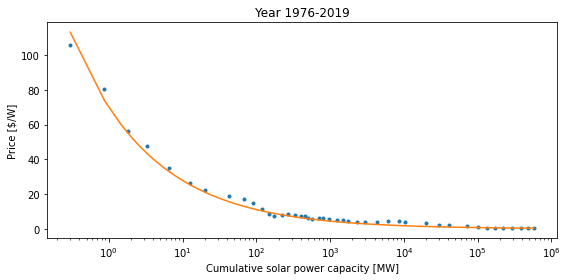

In [258]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(cumcap,price,'.')
ax.plot(x,y)
ax.set(xlabel='Cumulative solar power capacity [MW]', ylabel='Price [$/W]', title='Year 1976-2019')
#ax.set_yscale('log')
ax.set_xscale('log')
plt.tight_layout()

**Assuming a relative price uncertainty of 15%, fit the data with a power law: $f(x) = ax^{-b}$**

In [257]:
def powerlawfit(x,a,b):
    return a*x**(-b)

x = np.linspace(min(cumcap),max(cumcap),10**6)
y = powerlawfit(x,70,0.4)

In [259]:
def chisquarefit(x, y, ysigma, fitfunction, startparameters, plot=False):
    'Chi-square fit'
    chi2fit = Chi2Regression(fitfunction, x, y, ysigma)
    minuit_chi2 = Minuit(chi2fit, *startparameters)
    minuit_chi2.errordef = 1.0     
    minuit_chi2.migrad()
    
    'Parameters and uncertainties'
    par = minuit_chi2.values[:]   
    par_err = minuit_chi2.errors[:]
    
    'Chi-square value, number of degress of freedom and probability'
    chi2_value = minuit_chi2.fval 
    Ndof_value = len(x)-len(par)
    chi2_prob = stats.chi2.sf(chi2_value, Ndof_value)
    
    'Plotting'
    if plot==True:
        x_axis = np.linspace(min(x), max(x), 1000)
        
        d = {'Chi2':     chi2_value,
             'Ndof':     Ndof_value,
             'Prob':     chi2_prob,
            }
            
        fig, ax = plt.subplots(figsize=(14,10))
        ax.plot(x, y, 'k.', label='X')
        ax.plot(x_axis, fitfunction(x_axis, *minuit_chi2.values[:]), '-r', label='Chi2 fit model result') 
        ax.set(xlabel='X', ylabel='X', title='X')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.errorbar(x, y, ysigma, fmt='ro', ecolor='k', elinewidth=2, capsize=2, capthick=1)
        text = nice_string_output(d, extra_spacing=2, decimals=3)
        add_text_to_ax(0.80, 0.95, text, ax, fontsize=14)
    
    return chi2_value, Ndof_value, chi2_prob, par, par_err

In [260]:
price_sigma = price*0.15

(86.59818720575875,
 42,
 6.226507301332337e-05,
 [72.88263084201988, 0.38134521705865737],
 [3.3456001447625936, 0.0056836568919722665])

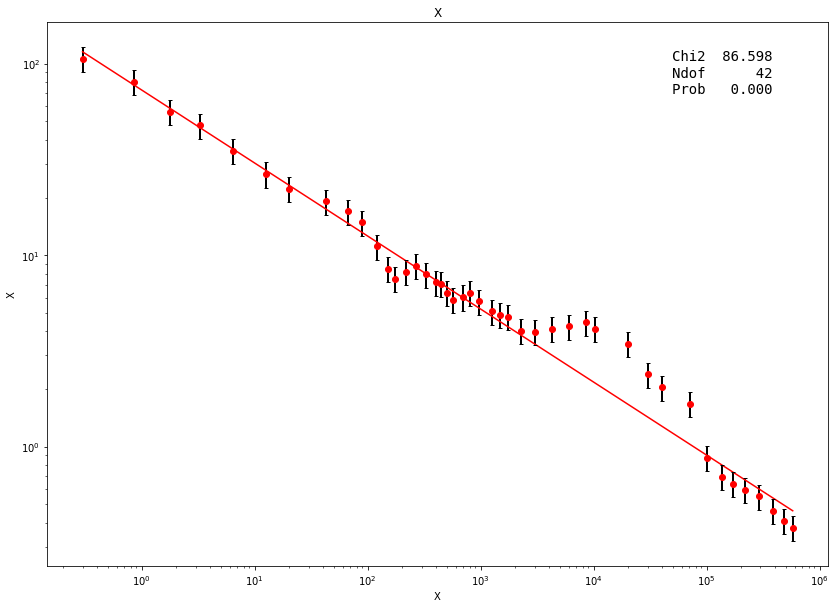

In [261]:
chisquarefit(cumcap, price, price_sigma, powerlawfit, [100,0.2], plot=True)

**Fit the cumulative solar power capacity as a function of year, and determine when you expect it to reach a million MW. What do you estimate the price per W to be then?**

In [262]:
year = year-min(year)

def fit(x,a,b,c,d,e):
    return a*np.exp(b*x + c*np.cos(d*x+e)) #



def exp(x,a,b):
    return a*np.exp(x*b)



xfit = np.linspace(min(year),max(year),1000)
yfit = fit(xfit,min(price),1.39,1,1,0)
#yexp = exp(xfit, min(price),0.33)

    

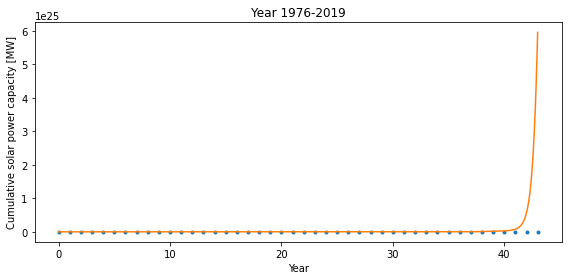

In [263]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(year,cumcap,'.')
ax.plot(xfit,yfit)
#ax.plot(xfit,yexp)

ax.set(xlabel='Year', ylabel='Cumulative solar power capacity [MW]', title='Year 1976-2019')
#ax.set_yscale('log')
#ax.set_xscale('log')
plt.tight_layout()

In [264]:
def chisquarefit2(x, y, ysigma, fitfunction, startparameters, plot=False):
    'Chi-square fit'
    chi2fit = Chi2Regression(fitfunction, x, y, ysigma)
    minuit_chi2 = Minuit(chi2fit, *startparameters)
    minuit_chi2.errordef = 1.0     
    minuit_chi2.migrad()
    
    'Parameters and uncertainties'
    par = minuit_chi2.values[:]   
    par_err = minuit_chi2.errors[:]
    
    'Chi-square value, number of degress of freedom and probability'
    chi2_value = minuit_chi2.fval 
    Ndof_value = len(x)-len(par)
    chi2_prob = stats.chi2.sf(chi2_value, Ndof_value)
    
    'Plotting'
    if plot==True:
        x_axis = np.linspace(min(x), max(x), 1000)
        
        d = {'Chi2':     chi2_value,
             'Ndof':     Ndof_value,
             'Prob':     chi2_prob,
            }
            
        fig, ax = plt.subplots(figsize=(14,10))
        ax.plot(x, y, 'k.', label='X')
        ax.plot(x_axis, fitfunction(x_axis, *minuit_chi2.values[:]), '-r', label='Chi2 fit model result') 
        ax.set(xlabel='X', ylabel='X', title='X')
        #ax.set_xscale('log')
        #ax.set_yscale('log')
        ax.errorbar(x, y, ysigma, fmt='ro', ecolor='k', elinewidth=2, capsize=2, capthick=1)
        text = nice_string_output(d, extra_spacing=2, decimals=3)
        add_text_to_ax(0.80, 0.95, text, ax, fontsize=14)
    
    return chi2_value, Ndof_value, chi2_prob, par, par_err

In [265]:
def fit(x,a,b):
    return a*x**b

(48111493956.32527,
 42,
 0.0,
 [2.335318611113528e-05, 6.306653149632062],
 [1.6259423424627672e-10, 1.588710179648943e-06])

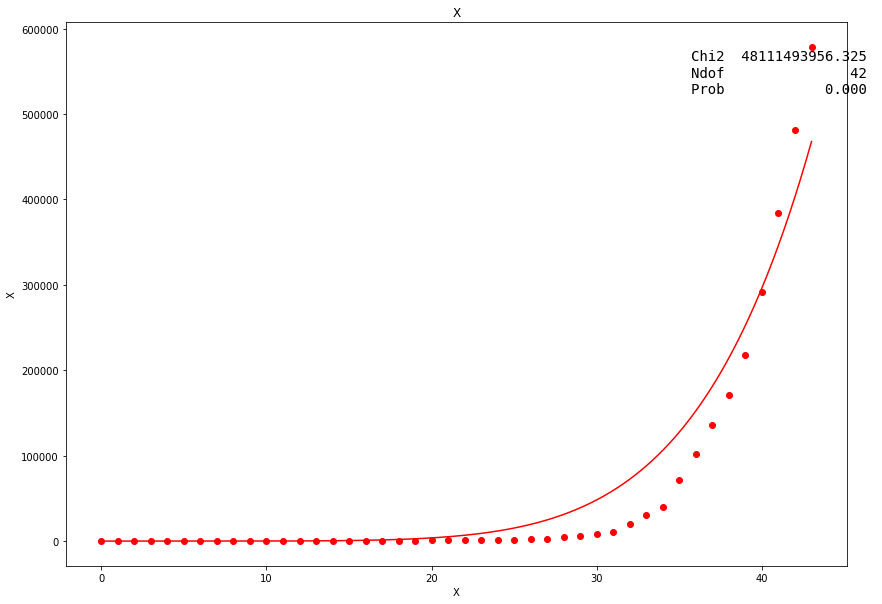

In [271]:
cumcap_sigma  = [1]*len(cumcap)
chisquarefit2(year, cumcap, cumcap_sigma, fit, [min(price),1.39], plot=True)

### 5.2 

 The number of daily Covid-19 PCR tests and positve cases can for the period 4th-18th
of January 2021 

**Given the number of daily tests Ti
, what is the average number of tests T in the period?**

In [267]:
date, Nt, Np = np.loadtxt("data_Covid19tests.txt", skiprows=2, unpack=True)

In [268]:
Nt_mean = sw.weightedmean(Nt, np.sqrt(Nt))

**Define the number of scaled positives (SPi) as the number of positives (Pi) times $(Ti/T)^{−0.7}$,
and fit the number of scale positive tests with SP(t) = SP0 ·R(t−t0)/tG , where tG = 4.7 days**

In [269]:
sp = Np*(Nt/Nt_mean[0])**(-0.7)

def sp_fit(t,sp0,R):
    t0, tg = 4, 4.7
    return sp0 * R**((t-t0)/tg)

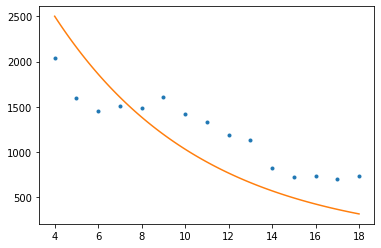

In [270]:
x = np.linspace(min(date),max(date),100)
y = sp_fit(x,2500,0.5)

plt.plot(date,sp,'.')
plt.plot(x,y)

In [ ]:
sp_sigma = 4.4*np.sqrt(sp)

In [ ]:
reload(sw);

In [ ]:
sw.chisquarefit(date, sp, sp_sigma, sp_fit, [2500,0.5], plot=True)

**How large a systematic uncertainty must be applied, for the fit to give a reasonable p-value**

**How large an uncertainty do you find on R, if tG has an uncertainty of ±1.0 days?**